# The Challenge and how I resolved it
Since our food image dataset has 101 classes, and each class has 1,000 images, so in total we have 101,000 images. Each image has over 500 by 500 resolution size. This is huge dataset for deep learning model and training process is very slow.

# Interacting with CLIP

This is the first part of report that shows how to download and run CLIP models, and perform zero-shot image classifications on 101-class American food. We only show essential codes which is used to illustrate our purple, while other supplemental and helper codes are hidden in this notebook-style report.

# Introduction to CLIP (Contrastive Language–Image Pre-training)



> "*We’re introducing a neural network called CLIP which efficiently learns visual concepts from natural language supervision. CLIP can be applied to any visual classification benchmark by simply providing the names of the visual categories to be recognized, similar to the “zero-shot” capabilities of GPT-2 and GPT-3.*"
[https://openai.com/blog/clip/](https://openai.com/blog/clip/)

# Architecture of CLIP model

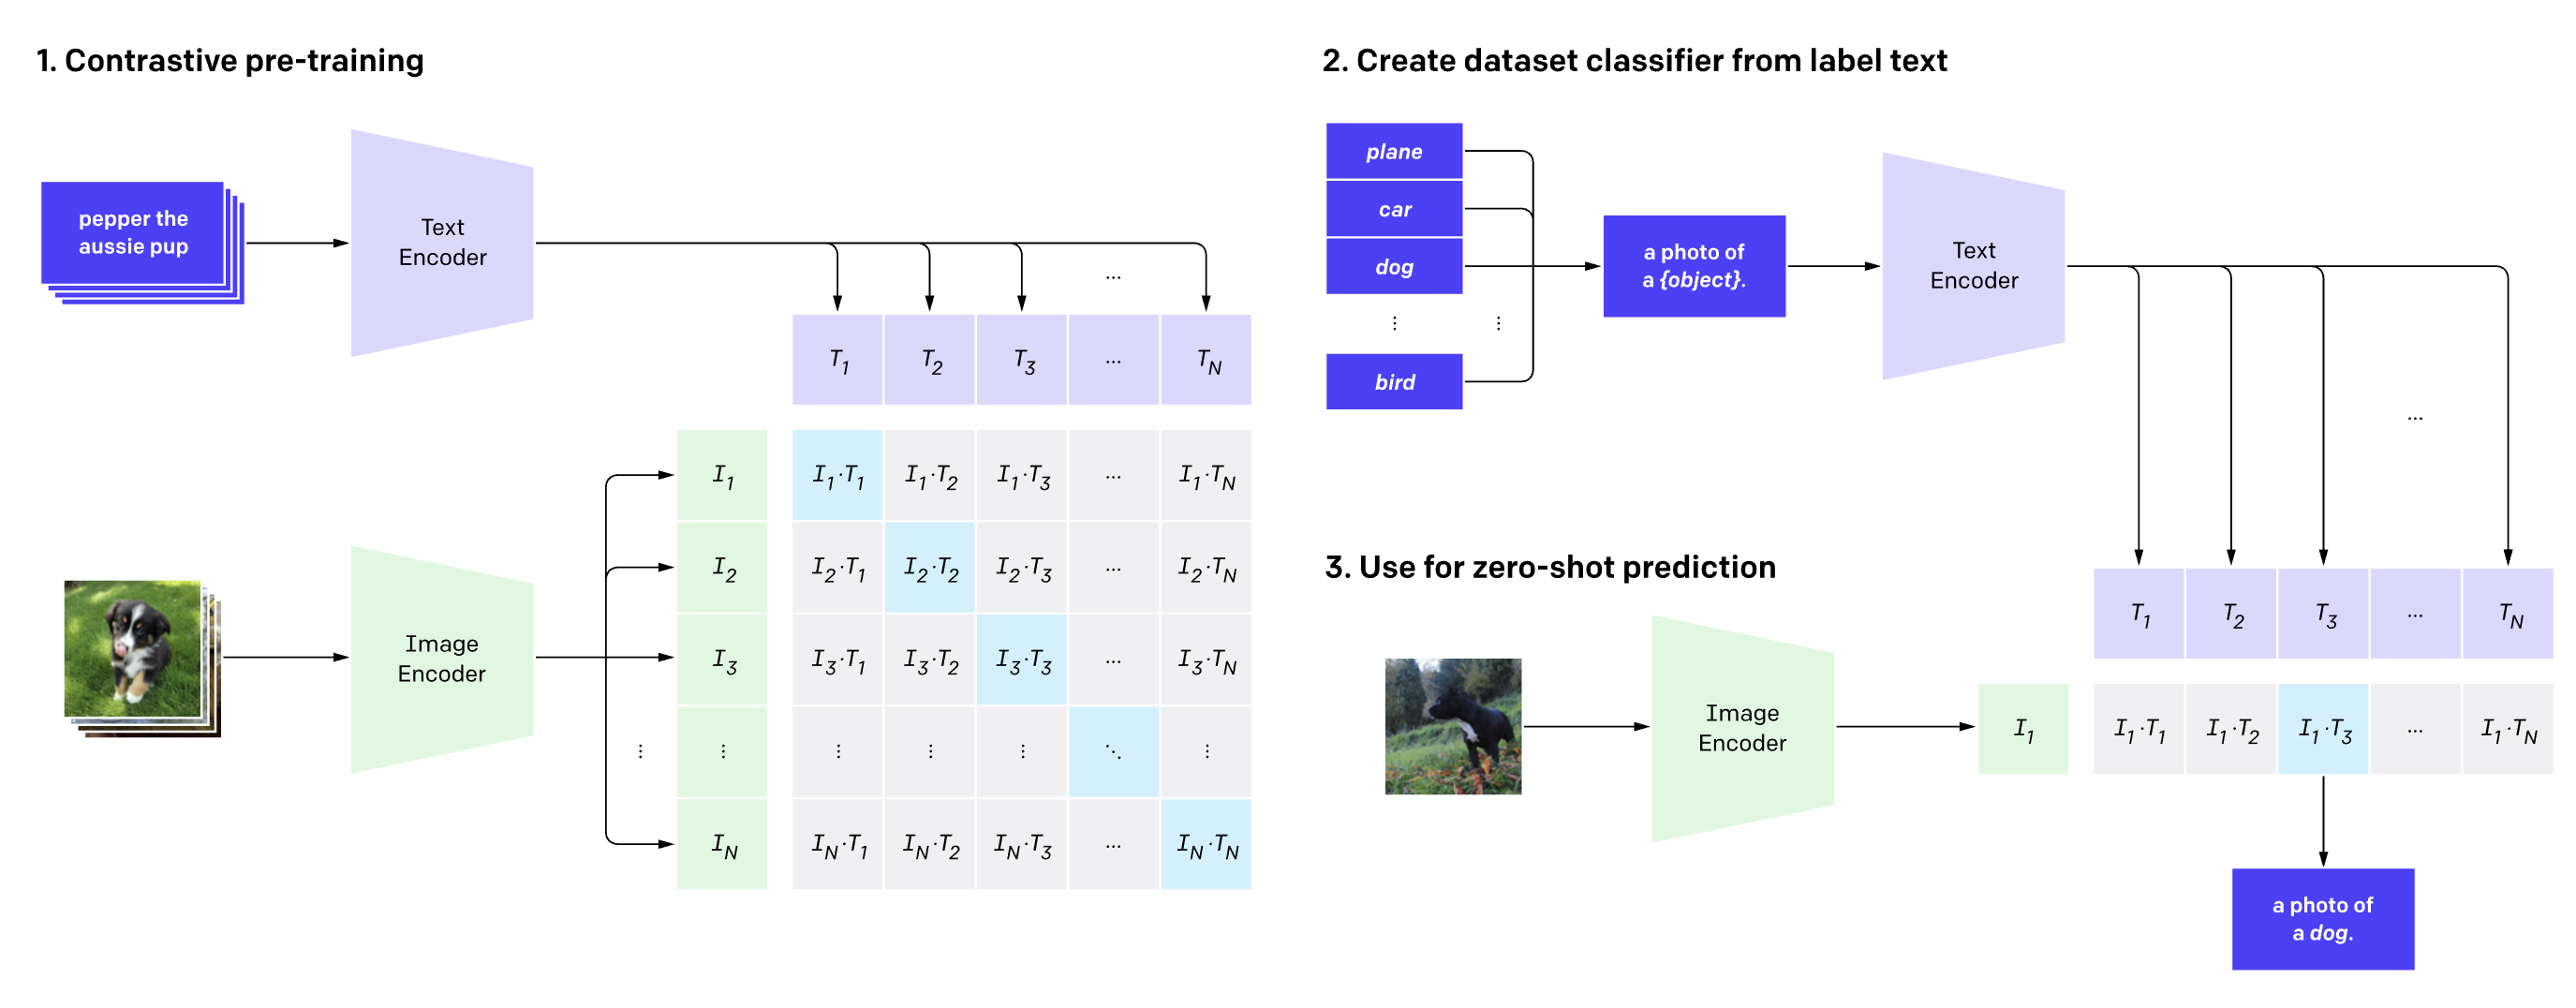

In [3]:
from IPython.display import Image
Image(filename='../../codes/clip.png') 

> "*CLIP pre-trains an image encoder and a text encoder to predict which images were paired with which texts in our dataset. We then use this behavior to turn CLIP into a zero-shot classifier. We convert all of a dataset’s classes into captions such as “a photo of a dog” and predict the class of the caption CLIP estimates best pairs with a given image.*"
[https://openai.com/blog/clip/](https://openai.com/blog/clip/)

# Mount my Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Print out image and label folders

In [4]:
% cd drive/MyDrive/Colab\ Notebooks/final/data/food-101/
% ls

/content/drive/MyDrive/Colab Notebooks/final/data/food-101
condacolab_install.log            meta/                          small_val/
densenet-121_model_best_model.pt  README.txt                     train/
images/                           resnet-50_model_best_model.pt  val/
license_agreement.txt             small_train/


# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

## Install conda in colab

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [5]:
! conda --version
! which conda

conda 4.11.0
/usr/local/bin/conda


## Install Pytorch 1.7 and its dependencies

In [2]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
| / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - pytorch=1.7.1
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    blas-2.106                 |              mkl          12 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   p

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w6gm2y81
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-w6gm2y81
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369094 sha256=aa0b0816369ab149132c372853a0b16538533c5173443ac11bd4534e7f62a951
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgl4324j/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [6]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.7.1


# Delete impaired food images and count the remaining number in original data

When I directly trained this dataset, I found it threw an error to me that some images couldn't be opened. So I wrote this short script to detect all impaired image in training and validation set and deleted them. It also took a while to run due to the same chanllege that this is huge dataset.

In [ ]:
all_folders = os.listdir("./images")
for folder in all_folders:
  all_filenames = os.listdir("./images/" + folder + "/")
  count = 0
  for i in all_filenames:
    try:
      test_image = Image.open("./images/" + folder + "/" + i)
    except:
      print(folder + " detects an impaired image: " + i)
      count = count + 1
      os.remove("./images/" + folder + "/" + i)
  print(folder + " found " + str(count) + " impaired images!")
  remaining = os.listdir("./images/" + folder + "/")
  print(folder + " has " + str(len(remaining)) + " images.")
  print("\n\n\n")

**After detecting and deleting, we found there is only one class, prime_rib, which contains impaired images that are unable to be opened by the image function. They are**

1. prime_rib detects an impaired image: 741587.jpg

2. prime_rib detects an impaired image: 348974.jpg

3. prime_rib detects an impaired image: 1953571.jpg

4. prime_rib detects an impaired image: 3595631.jpg

5. prime_rib detects an impaired image: 2597471.jpg

**prime_rib found 5 impaired images!**

**prime_rib has 995 images.**

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [7]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [8]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:16<00:00, 21.1MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


As seen from this model parameters, this CLIP model is still like other deep CNN model with around 0.14 billion parameters. The input resolution is also like other pretrained model having 224 by 224, beyond image, this model also needs context text to predict labels.

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fbfb9ed40e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [10]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed all 101,000 food images and setting up all 101 label descriptions to the model, then compute text feature and image feature.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Randomly Show 10 class food original image

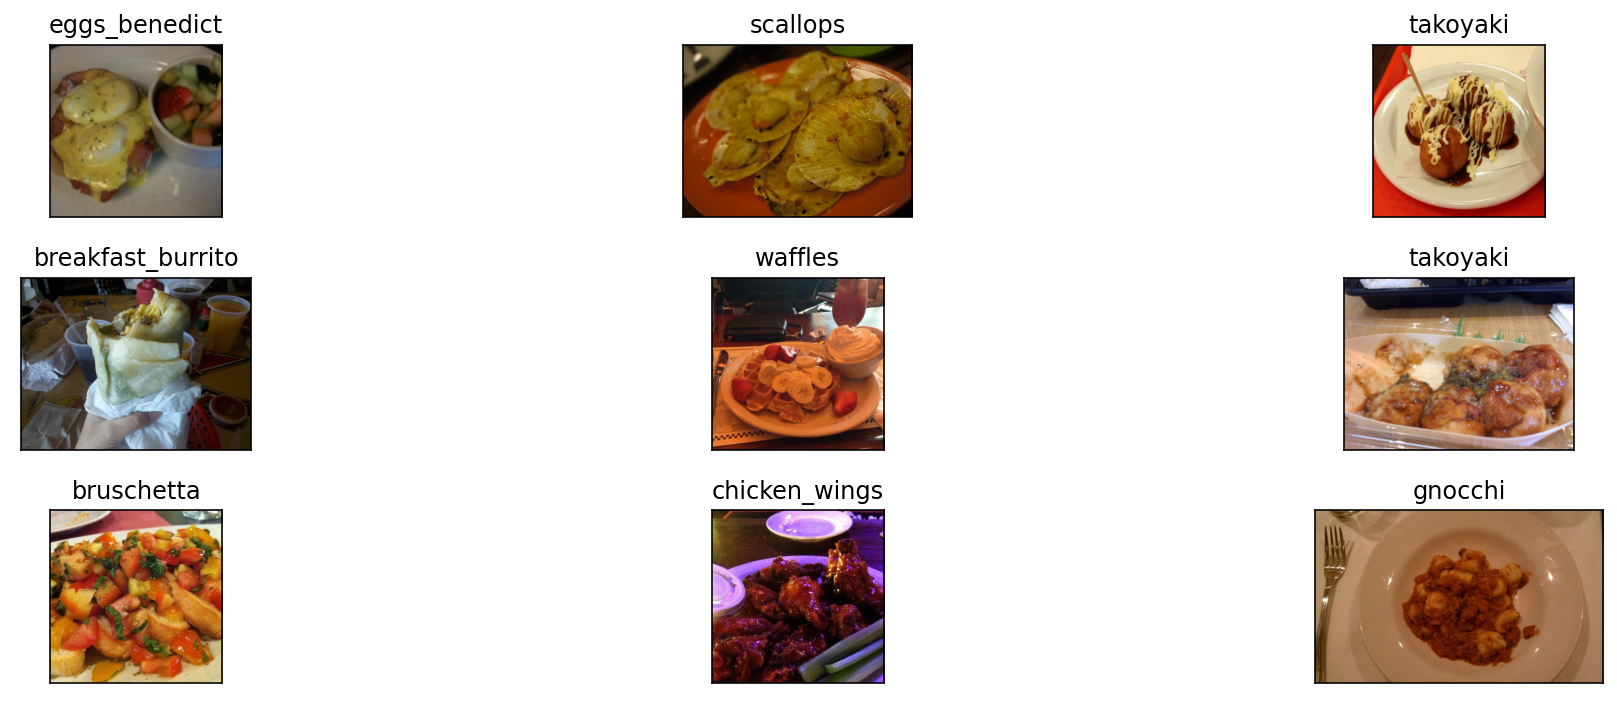

In [12]:
all_folders = os.listdir("./images")
random_index = np.random.randint(low=0, high=len(all_folders), size=9)
select_class = [all_folders[i] for i in random_index]
select_class

plt.figure(figsize=(16, 5))
count = 1

for filename in select_class:

  all_images = os.listdir(os.path.join("./images/" + filename))
  random_ind = np.random.randint(low=0, high=len(all_images), size=1)[0]
  image = Image.open(os.path.join("./images/" + filename + "/" + all_images[random_ind])).convert("RGB")

  plt.subplot(3, 3, count)
  plt.imshow(image)
  plt.title(f"{filename}")
  plt.xticks([])
  plt.yticks([])
  count = count + 1

plt.tight_layout()

# Use all 101 labels to generate text descriptions for model to pair, then compute text features

In [12]:
labels = open('./meta/labels.txt', 'r')
labels = labels.readlines()
labels = [i.strip() for i in labels]

text_descriptions = [f"a photo of {label}, a type of food." for label in labels]
text_tokens = clip.tokenize(text_descriptions).cuda()


with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Convert all 101,000 food images into each 1 by 512 image features, them compute cosine similarity between text features and images feature, find the maximum one 

In [13]:
all_folders = os.listdir("./images")[:10]
accuracy = []

for i in all_folders:
  all_png = os.listdir("./images/" + i)
  original_images = [Image.open("./images/" + i + "/" + j).convert("RGB") for j in all_png]

  images = [preprocess(j) for j in original_images]
  image_input = torch.tensor(np.stack(images)).cuda()

  with torch.no_grad():
      image_features = model.encode_image(image_input).float()

  text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  top_probs, top_labels = text_probs.cpu().topk(10, dim=-1)

  true_label = list(map(lambda x: x.replace(" ", "_").lower(), labels)).index(i)
  acc = np.sum((top_labels[:, 0] == true_label).tolist()) / top_labels.shape[0]
  accuracy.append(acc)
  print(i, "has", image_features.shape[0], "images with", "accuracy:", acc)

samosa has 1000 images with accuracy: 0.771
sashimi has 1000 images with accuracy: 0.887
spring_rolls has 1000 images with accuracy: 0.891
panna_cotta has 1000 images with accuracy: 0.712
greek_salad has 1000 images with accuracy: 0.813
foie_gras has 1000 images with accuracy: 0.599
tacos has 1000 images with accuracy: 0.76
pad_thai has 1000 images with accuracy: 0.927
ramen has 1000 images with accuracy: 0.733
pulled_pork_sandwich has 1000 images with accuracy: 0.89


In [14]:
np.mean(accuracy)

0.7983

```
samosa has 1000 images with accuracy: 0.888
sashimi has 1000 images with accuracy: 0.889
spring_rolls has 1000 images with accuracy: 0.903
panna_cotta has 1000 images with accuracy: 0.777
greek_salad has 1000 images with accuracy: 0.87
foie_gras has 1000 images with accuracy: 0.675
tacos has 1000 images with accuracy: 0.741
pad_thai has 1000 images with accuracy: 0.957
ramen has 1000 images with accuracy: 0.76
pulled_pork_sandwich has 1000 images with accuracy: 0.922
bibimbap has 1000 images with accuracy: 0.93
beignets has 1000 images with accuracy: 0.919
crab_cakes has 1000 images with accuracy: 0.905
risotto has 1000 images with accuracy: 0.844
steak has 1000 images with accuracy: 0.391
frozen_yogurt has 1000 images with accuracy: 0.961
club_sandwich has 1000 images with accuracy: 0.929
carrot_cake has 1000 images with accuracy: 0.847
falafel has 1000 images with accuracy: 0.854
chicken_wings has 1000 images with accuracy: 0.934
chocolate_cake has 1000 images with accuracy: 0.828
tiramisu has 1000 images with accuracy: 0.817
spaghetti_bolognese has 1000 images with accuracy: 0.944
garlic_bread has 1000 images with accuracy: 0.825
scallops has 1000 images with accuracy: 0.772
edamame has 1000 images with accuracy: 0.993
pancakes has 1000 images with accuracy: 0.903
red_velvet_cake has 1000 images with accuracy: 0.918
deviled_eggs has 1000 images with accuracy: 0.935
peking_duck has 1000 images with accuracy: 0.889
guacamole has 1000 images with accuracy: 0.928
clam_chowder has 1000 images with accuracy: 0.908
croque_madame has 1000 images with accuracy: 0.889
french_onion_soup has 1000 images with accuracy: 0.891
beef_carpaccio has 1000 images with accuracy: 0.89
donuts has 1000 images with accuracy: 0.833
ravioli has 1000 images with accuracy: 0.687
spaghetti_carbonara has 1000 images with accuracy: 0.961
french_fries has 1000 images with accuracy: 0.92
shrimp_and_grits has 1000 images with accuracy: 0.917
dumplings has 1000 images with accuracy: 0.909
tuna_tartare has 1000 images with accuracy: 0.77
sushi has 1000 images with accuracy: 0.863
takoyaki has 1000 images with accuracy: 0.937
breakfast_burrito has 1000 images with accuracy: 0.836
macarons has 1000 images with accuracy: 0.958
waffles has 1000 images with accuracy: 0.901
seaweed_salad has 1000 images with accuracy: 0.972
cannoli has 1000 images with accuracy: 0.939
pizza has 1000 images with accuracy: 0.941
hot_and_sour_soup has 1000 images with accuracy: 0.922
prime_rib has 995 images with accuracy: 0.8753768844221106
ice_cream has 1000 images with accuracy: 0.623
pho has 1000 images with accuracy: 0.946
lobster_roll_sandwich has 1000 images with accuracy: 0.953
nachos has 1000 images with accuracy: 0.949
oysters has 1000 images with accuracy: 0.974
escargots has 1000 images with accuracy: 0.78
strawberry_shortcake has 1000 images with accuracy: 0.843
lobster_bisque has 1000 images with accuracy: 0.891
chicken_curry has 1000 images with accuracy: 0.82
bread_pudding has 1000 images with accuracy: 0.774
grilled_cheese_sandwich has 1000 images with accuracy: 0.799
baby_back_ribs has 1000 images with accuracy: 0.828
caprese_salad has 1000 images with accuracy: 0.887
pork_chop has 1000 images with accuracy: 0.798
beet_salad has 1000 images with accuracy: 0.763
paella has 1000 images with accuracy: 0.891
bruschetta has 1000 images with accuracy: 0.815
hummus has 1000 images with accuracy: 0.835
grilled_salmon has 1000 images with accuracy: 0.843
cheese_plate has 1000 images with accuracy: 0.945
filet_mignon has 1000 images with accuracy: 0.756
mussels has 1000 images with accuracy: 0.943
cheesecake has 1000 images with accuracy: 0.73
gyoza has 1000 images with accuracy: 0.796
chicken_quesadilla has 1000 images with accuracy: 0.896
huevos_rancheros has 1000 images with accuracy: 0.879
hot_dog has 1000 images with accuracy: 0.922
fish_and_chips has 1000 images with accuracy: 0.924
onion_rings has 1000 images with accuracy: 0.893
omelette has 1000 images with accuracy: 0.858
apple_pie has 1000 images with accuracy: 0.791
hamburger has 1000 images with accuracy: 0.867
beef_tartare has 1000 images with accuracy: 0.751
baklava has 1000 images with accuracy: 0.831
chocolate_mousse has 1000 images with accuracy: 0.711
miso_soup has 1000 images with accuracy: 0.861
gnocchi has 1000 images with accuracy: 0.782
eggs_benedict has 1000 images with accuracy: 0.932
caesar_salad has 1000 images with accuracy: 0.941
macaroni_and_cheese has 1000 images with accuracy: 0.819
french_toast has 1000 images with accuracy: 0.869
cup_cakes has 1000 images with accuracy: 0.741
poutine has 1000 images with accuracy: 0.916
lasagna has 1000 images with accuracy: 0.845
fried_calamari has 1000 images with accuracy: 0.904
churros has 1000 images with accuracy: 0.909
fried_rice has 1000 images with accuracy: 0.923
creme_brulee has 1000 images with accuracy: 0.928
ceviche has 1000 images with accuracy: 0.732
```

# Conclusion

These are all accuracy for each class. As we can see, the accuracy is pretty high around 90% for some classes, this suggests this CLIP zero-shot model performs very well on these 101,000 huge image dataset. We have 101 labels for zero-shot to predict, this is a tough task, because the random guess for each image is less than 1%, but our CLIP model predict around 90% accuracy. This is amazing. Actually, CLIP architecture provides four models to use, 

`'RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16'`.

**After trying each one, I found the `ViT-B/16` performs better than other models, so I chose this one to train for final result. `RN50` gives around 77% accuracy, and `RN101` gives around 79% accuracy while `ViT-B/16` gives around 83.82%.**

The challenge is that when I tried model `RN50x4` and `RN50x16`, the colab Pro gave me an error that `Out of CUDA memory` which means currently it can't run zero-shot models of these two. This is limitation of our hardware. I wish I can run all of the available models to compare their performance. I found these two models have much larger pretrain parameters like over 600MB when downloading them. This is also Deep Learning limitation because it requires a high-performance architecture.